<a href="https://colab.research.google.com/github/biniyam-mulugeta/test_co_2/blob/main/google_resnet_120_v_new_best200e_8C1_with60-40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np 
import keras
from keras.models import Model
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,DepthwiseConv2D,Add#,Dense,Dropout,Conv2D
from keras.applications import densenet,mobilenet, mobilenet_v2,efficientnet#densenetmobilenet_v2#,efficientnet,vgg16,densenet
from keras.applications import vgg19,resnet
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
#from keras.utils.all_utils import to_categorical
from sklearn import preprocessing
from skimage.filters import threshold_otsu
import cv2
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
#import zipfile
%matplotlib inline

In [6]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from skimage import io

In [7]:
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,Input,Dense,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.layers import MaxPool2D,AveragePooling2D

In [8]:
import pandas as pd

In [9]:
SIZE = 32
data_image = []
data_label = []
for dir_path in glob.glob("/content/drive/My Drive/coffee_dataset/*"):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        
        img = cv2.GaussianBlur(img,(5,5),0)
  
        #img = otsu_segmentation(img)]

        data_image.append(img)
        data_label.append(label)
data_image = np.array(data_image)
data_label = np.array(data_label)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/coffee_dataset/phoma_cro/456_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_5.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_6.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_7.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_8.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/460.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461_1.jpg
/content/dr

In [10]:
le = preprocessing.LabelEncoder()
le.fit(data_label)
train_labe_encoded = le.transform(data_label)

In [11]:
x_train,y_train = data_image,train_labe_encoded
x_train = x_train/255.0

In [12]:
from keras.utils.all_utils import to_categorical
y_train_one_hot = to_categorical(y_train)

### train test validate splite

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_tr,x_te,y_tr,y_te = train_test_split(x_train,y_train_one_hot,test_size=0.40,shuffle=True,random_state=42,stratify=y_train_one_hot)

In [15]:

print(x_tr.shape,'----',y_tr.shape)
print(x_te.shape,'----',y_te.shape)

(4240, 32, 32, 3) ---- (4240, 8)
(2827, 32, 32, 3) ---- (2827, 8)


In [16]:
x_v,x_tes,y_v,y_tes = train_test_split(x_te,y_te,test_size=0.5,shuffle=True,random_state=42,stratify=y_te)

In [17]:
shape = (32,32,3)

### GoogleNet

In [18]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [19]:
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [20]:
input_layer = Input(shape=shape)

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(6, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

### ResNet

In [21]:
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x

In [22]:
inp = Input(shape = shape)
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
x = res_layer(x,64,dropout = 0.3)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(7,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")

### proposed model

In [23]:
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -3).output
out = concatenate([out1,out2])

out = Dense(64,activation='relu')(out)
out = Dropout(0.340)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.45)(out)
out = Dense(256,activation='relu')(out)
#out = Dropout(0.50)(out)


output = Dense(8,activation='softmax')(out)

In [24]:
e_model = Model(inputs = [google_net.input,resnet_model.input],outputs = output)

In [25]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
e_model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
history = e_model.fit([x_tr,x_tr],y_tr,epochs=200,validation_data=([x_v,x_v],y_v))

Epoch 1/200
133/133 [==============================] - 18s 27ms/step - loss: 0.0937 - accuracy: 0.3502 - val_loss: 0.0665 - val_accuracy: 0.6122
Epoch 2/200
133/133 [==============================] - 3s 20ms/step - loss: 0.0619 - accuracy: 0.5927 - val_loss: 0.0492 - val_accuracy: 0.7197
Epoch 3/200
133/133 [==============================] - 3s 20ms/step - loss: 0.0518 - accuracy: 0.6679 - val_loss: 0.0376 - val_accuracy: 0.7672
Epoch 4/200
133/133 [==============================] - 3s 20ms/step - loss: 0.0474 - accuracy: 0.7050 - val_loss: 0.0362 - val_accuracy: 0.7870
Epoch 5/200
133/133 [==============================] - 3s 19ms/step - loss: 0.0427 - accuracy: 0.7358 - val_loss: 0.0347 - val_accuracy: 0.7594
Epoch 6/200
133/133 [==============================] - 3s 19ms/step - loss: 0.0396 - accuracy: 0.7519 - val_loss: 0.0309 - val_accuracy: 0.8415
Epoch 7/200
133/133 [==============================] - 3s 19ms/step - loss: 0.0377 - accuracy: 0.7736 - val_loss: 0.0300 - val_accuracy

### plot the result

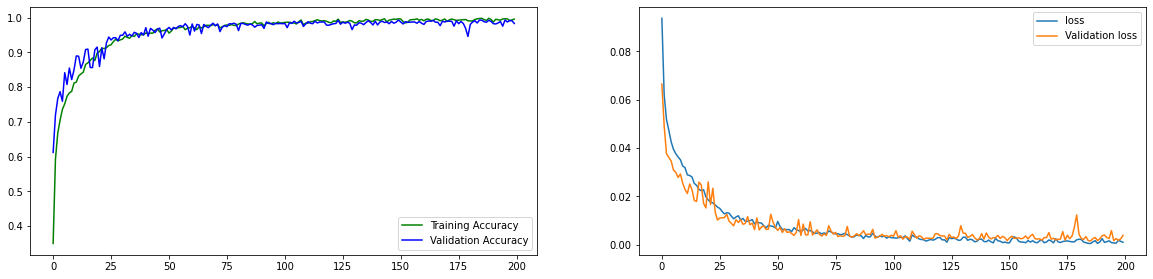

In [26]:
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.figure(figsize=(20,15))
  epochs = range(len(acc))
  plt.subplot(321)
  plt.plot(epochs, acc, 'g', label = 'Training Accuracy')
  plt.plot(epochs, val_acc, 'b', label= 'Validation Accuracy')
  #plt.title(f'Training and Validation accuray {i}')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2,bottom=0.1)

  plt.subplot(322)
  plt.plot(epochs, loss,'', label = 'loss')
  plt.plot(epochs, val_loss,'', label = 'Validation loss')
  #plt.title(f'Training and Validation loss {i}')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2)
  #show the graph
  plt.show()

### make prdiction and do confusion matrix

In [27]:
labeles = ['CBD','CB_Healthy','CWD','Healthy','Cercospora','Mold','Phoma','CLR']

### confusion matrix Training

In [28]:
pip install pretty_confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 103 kB 8.2 MB/s 
     |████████████████████████████████| 156 kB 10.7 MB/s 
     |████████████████████████████████| 73 kB 476 kB/s 
     |████████████████████████████████| 11.2 MB 204 kB/s 
     |████████████████████████████████| 199 kB 52.8 MB/s 
     |████████████████████████████████| 843 kB 10.3 MB/s 
     |████████████████████████████████| 41 kB 315 kB/s 
     |████████████████████████████████| 68 kB 5.0 MB/s 
     |████████████████████████████████| 944 kB 21.3 MB/s 
     |████████████████████████████████| 98 kB 4.6 MB/s 
     |████████████████████████████████| 596 kB 51.0 MB/s 
     |████████████████████████████████| 10.1 MB 13.4 MB/s 
     |████████████████████████████████| 466 kB 26.7 MB/s 
  Attempting uninstall: tomli
    Found existing installation: tomli 2.0.1
    Uninstalling tomli-2.0.1:
      Successfully uninstalled tomli-2.0.1
  Attem

In [29]:
from pretty_confusion_matrix import pp_matrix,pp_matrix_from_data

In [30]:
pred_tr = e_model.predict([x_tr,x_tr])
round_pred_tr = np.argmax(pred_tr,axis=-1)
y_tr_r = np.argmax(y_tr,axis=-1)
#print("Acuracy of the Testing is : " ,pred)

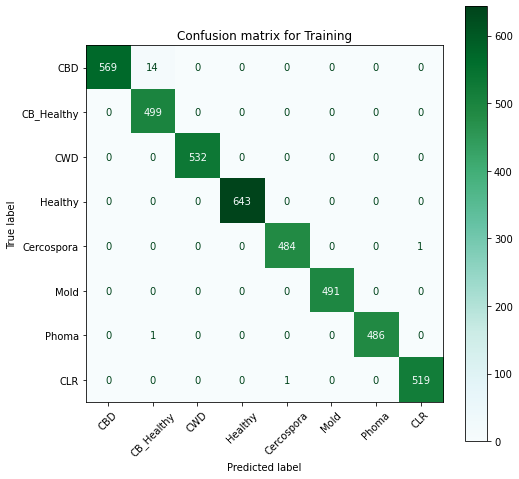

In [31]:
fig,ax = plt.subplots(figsize=(8,8)) 
cm = confusion_matrix(y_tr_r, round_pred_tr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
disp.ax_.set_title("Confusion matrix for Training")
plt.show()

In [32]:
print(classification_report(y_tr_r,round_pred_tr))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       583
           1       0.97      1.00      0.99       499
           2       1.00      1.00      1.00       532
           3       1.00      1.00      1.00       643
           4       1.00      1.00      1.00       485
           5       1.00      1.00      1.00       491
           6       1.00      1.00      1.00       487
           7       1.00      1.00      1.00       520

    accuracy                           1.00      4240
   macro avg       1.00      1.00      1.00      4240
weighted avg       1.00      1.00      1.00      4240



/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

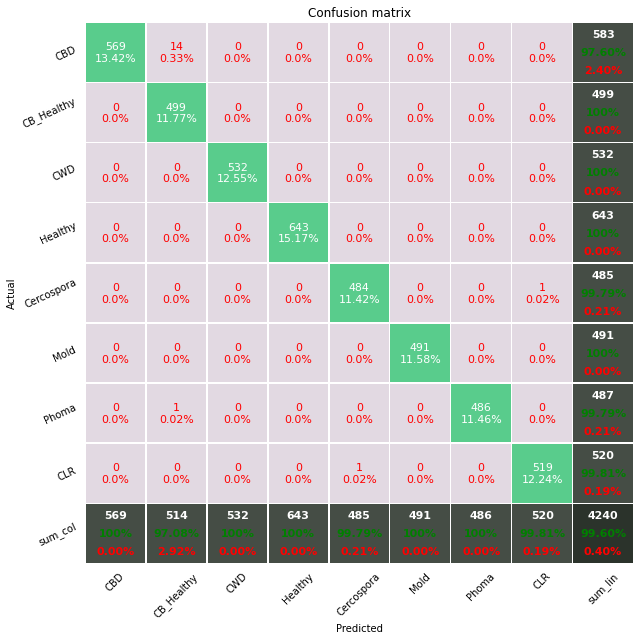

In [33]:
pp_matrix_from_data(y_tr_r, round_pred_tr,cmap='twilight',columns=labeles,figsize=[8,8],pred_val_axis='x')

### validation confusion matrix

In [34]:
pred_v = e_model.predict([x_v,x_v])
round_pred_v = np.argmax(pred_v,axis=-1)
y_v_r = np.argmax(y_v,axis=-1)

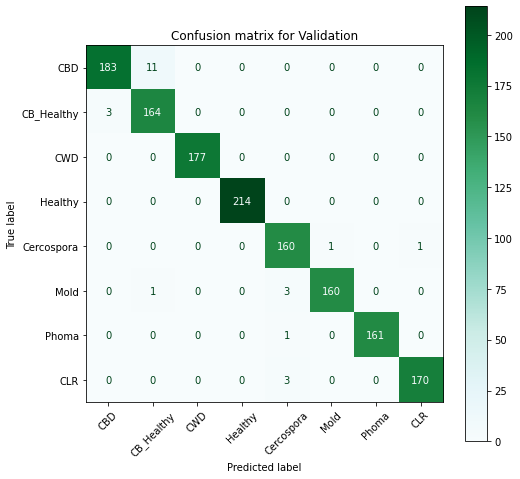

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       194
           1       0.93      0.98      0.96       167
           2       1.00      1.00      1.00       177
           3       1.00      1.00      1.00       214
           4       0.96      0.99      0.97       162
           5       0.99      0.98      0.98       164
           6       1.00      0.99      1.00       162
           7       0.99      0.98      0.99       173

    accuracy                           0.98      1413
   macro avg       0.98      0.98      0.98      1413
weighted avg       0.98      0.98      0.98      1413



In [35]:
fig,ax = plt.subplots(figsize=(8,8)) 
cm = confusion_matrix(y_v_r, round_pred_v)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
disp.ax_.set_title("Confusion matrix for Validation")
plt.show()
print(classification_report(y_v_r,round_pred_v))

/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

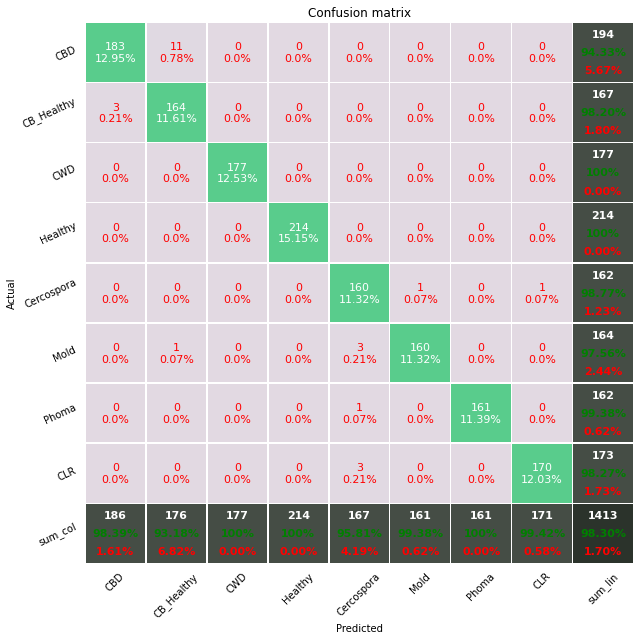

In [36]:
pp_matrix_from_data(y_v_r, round_pred_v,cmap='twilight',columns=labeles,figsize=[8,8],pred_val_axis='x')

### confusion matrix Testing

In [37]:
pred_t = e_model.predict([x_tes,x_tes])
round_pred_t = np.argmax(pred_t,axis=-1)
y_tes_r = np.argmax(y_tes,axis=-1)

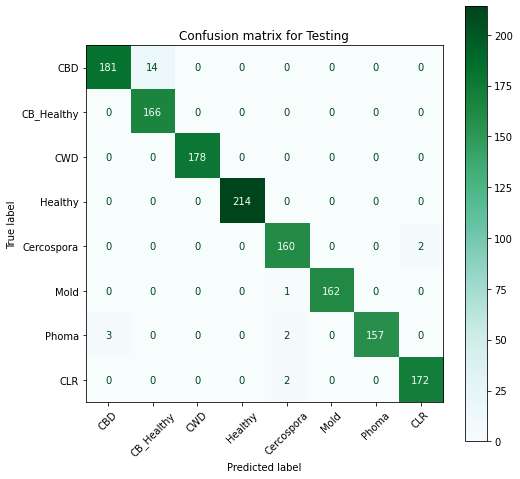

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       195
           1       0.92      1.00      0.96       166
           2       1.00      1.00      1.00       178
           3       1.00      1.00      1.00       214
           4       0.97      0.99      0.98       162
           5       1.00      0.99      1.00       163
           6       1.00      0.97      0.98       162
           7       0.99      0.99      0.99       174

    accuracy                           0.98      1414
   macro avg       0.98      0.98      0.98      1414
weighted avg       0.98      0.98      0.98      1414



In [38]:
fig,ax = plt.subplots(figsize=(8,8)) 
cm = confusion_matrix(y_tes_r, round_pred_t)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
disp.ax_.set_title("Confusion matrix for Testing")
plt.show()
print(classification_report(y_tes_r,round_pred_t))

/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

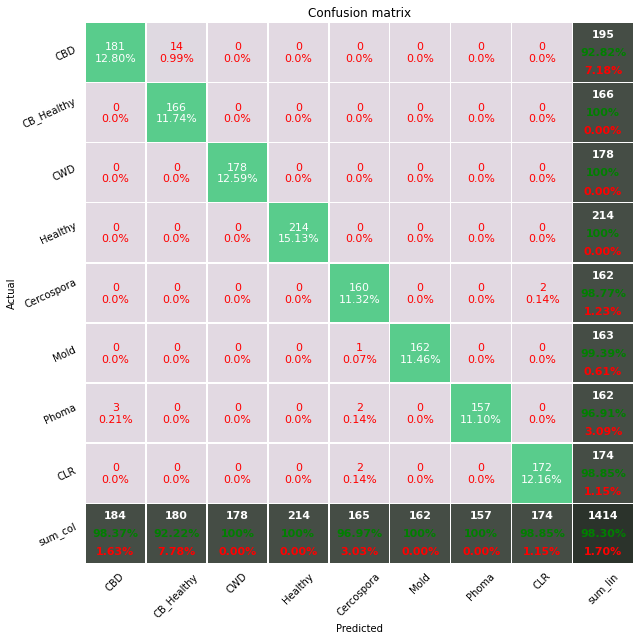

In [39]:
pp_matrix_from_data(y_tes_r, round_pred_t,cmap='twilight',columns=labeles,figsize=[8,8],pred_val_axis='x')